In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check and cleaning
*By Jackson Baker*

- Our original plan was to examine this dataset from a classification perspective and attempt to determine whether or not a certain movie would be likely to win an Oscar, so we turned many of the Oscar related columns in our dataset to numeric 1s and 0s rather than the categorical "Yes" or "No' options that were already present.

In [2]:
movies = pd.read_csv('movies.csv')

In [3]:
# Changing some binary string columns to binary numeric
movies.loc[movies.Oscar_Best_Picture_won == 'Yes', 'Oscar_Best_Picture_won'] = 1
movies.loc[movies.Oscar_Best_Picture_won == 'No', 'Oscar_Best_Picture_won'] = 0
movies.loc[movies.Oscar_Best_Picture_nominated == 'Yes', 'Oscar_Best_Picture_nominated'] = 1
movies.loc[movies.Oscar_Best_Picture_nominated == 'No', 'Oscar_Best_Picture_nominated'] = 0

movies.loc[movies.Oscar_Best_Director_won == 'Yes', 'Oscar_Best_Director_won'] = 1
movies.loc[movies.Oscar_Best_Director_won == 'No', 'Oscar_Best_Director_won'] = 0
movies.loc[movies.Oscar_Best_Director_nominated == 'Yes', 'Oscar_Best_Director_nominated'] = 1
movies.loc[movies.Oscar_Best_Director_nominated == 'No', 'Oscar_Best_Director_nominated'] = 0

movies.loc[movies.Oscar_Best_Actor_won == 'Yes', 'Oscar_Best_Actor_won'] = 1
movies.loc[movies.Oscar_Best_Actor_won == 'No', 'Oscar_Best_Actor_won'] = 0
movies.loc[movies.Oscar_Best_Actor_nominated == 'Yes', 'Oscar_Best_Actor_nominated'] = 1
movies.loc[movies.Oscar_Best_Actor_nominated == 'No', 'Oscar_Best_Actor_nominated'] = 0

movies.loc[movies.Oscar_Best_Actress_won == 'Yes', 'Oscar_Best_Actress_won'] = 1
movies.loc[movies.Oscar_Best_Actress_won == 'No', 'Oscar_Best_Actress_won'] = 0
movies.loc[movies.Oscar_Best_Actress_nominated == 'Yes', 'Oscar_Best_Actress_nominated'] = 1
movies.loc[movies.Oscar_Best_Actress_nominated == 'No', 'Oscar_Best_Actress_nominated'] = 0

In [4]:
# There were many columns that existed in the data as strings of numbers so we made certain that all of the following columns were 
# numeric in nature before proceeding.

movies['metascore'] = pd.to_numeric(movies['metascore'])
movies['Oscar_Best_Picture_won'] = pd.to_numeric(movies['Oscar_Best_Picture_won'])
movies['Oscar_Best_Director_nominated'] = pd.to_numeric(movies['Oscar_Best_Director_nominated'])
movies['Oscar_Best_Actor_nominated'] = pd.to_numeric(movies['Oscar_Best_Actor_nominated'])
movies['Oscar_Best_Actress_nominated'] = pd.to_numeric(movies['Oscar_Best_Actress_nominated'])
movies['Golden_Globes_nominated'] = pd.to_numeric(movies['Golden_Globes_nominated'])
movies['BAFTA_nominated'] = pd.to_numeric(movies['BAFTA_nominated'])
movies['month'] = pd.to_numeric(movies['release_date.month'])
movies['votes'] = pd.to_numeric(movies['votes'])
movies['gross'] = pd.to_numeric(movies['gross'])

In [5]:
# Getting the columns that were most relevant and important to our analysis
movies_new = movies[['year', 'movie', 'certificate', 'genre', 'duration', 'rate', 'metascore', 'votes', 'gross', 
                   'release_date', 'user_reviews', 'critic_reviews', 'popularity', 'awards_wins', 'awards_nominations',
                   'Oscar_nominated', 'month']]

# Removing entries in the certificate column that were irrelevant to our inference goals
new_movies_new = movies_new.loc[movies['certificate'] != 'Not Rated']
new_movies_new = new_movies_new.loc[movies['certificate'] != 'TV-MA']

In [13]:
# Filling in NA values in some of the categories for use in the development of the model
pop_mean=new_movies_new['popularity'].mean()
new_movies_new['popularity'].fillna(value=pop_mean, inplace=True)

dur_mean=new_movies_new['duration'].mean()
new_movies_new['duration'].fillna(value=dur_mean, inplace=True)

rate_mean=new_movies_new['rate'].mean()
new_movies_new['rate'].fillna(value=rate_mean, inplace=True)

rev_mean=new_movies_new['user_reviews'].mean()
new_movies_new['user_reviews'].fillna(value=rev_mean, inplace=True)

### Data preparation
*By Jackson Baker*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We needed to split our data into a test and train data set and settled on a 60% train and 40% test split to use for our model development. 

2. We binned the awards_nominations column because many movies had very few nominations and only a few had money. We wanted to ensure that adequate weight was given to movies that won many awards.

In [7]:
# Setting a random seed for reproducible results
np.random.seed(2)

# Splitting data into a train and test data set
train = new_movies_new.sample(round(movies_new.shape[0]*0.6))
test = new_movies_new.drop(train.index)

In [8]:
# Binning awards_nominations for both train and test datasets
train['award_noms_binned'] = pd.cut(train['awards_nominations'],bins = (-0.001,4,12,30,101),labels = ['Bin1','Bin2','Bin3','Bin4'])
test['award_noms_binned'] = pd.cut(test['awards_nominations'],bins = (-0.001,4,12,30,101),labels = ['Bin1','Bin2','Bin3','Bin4'])

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

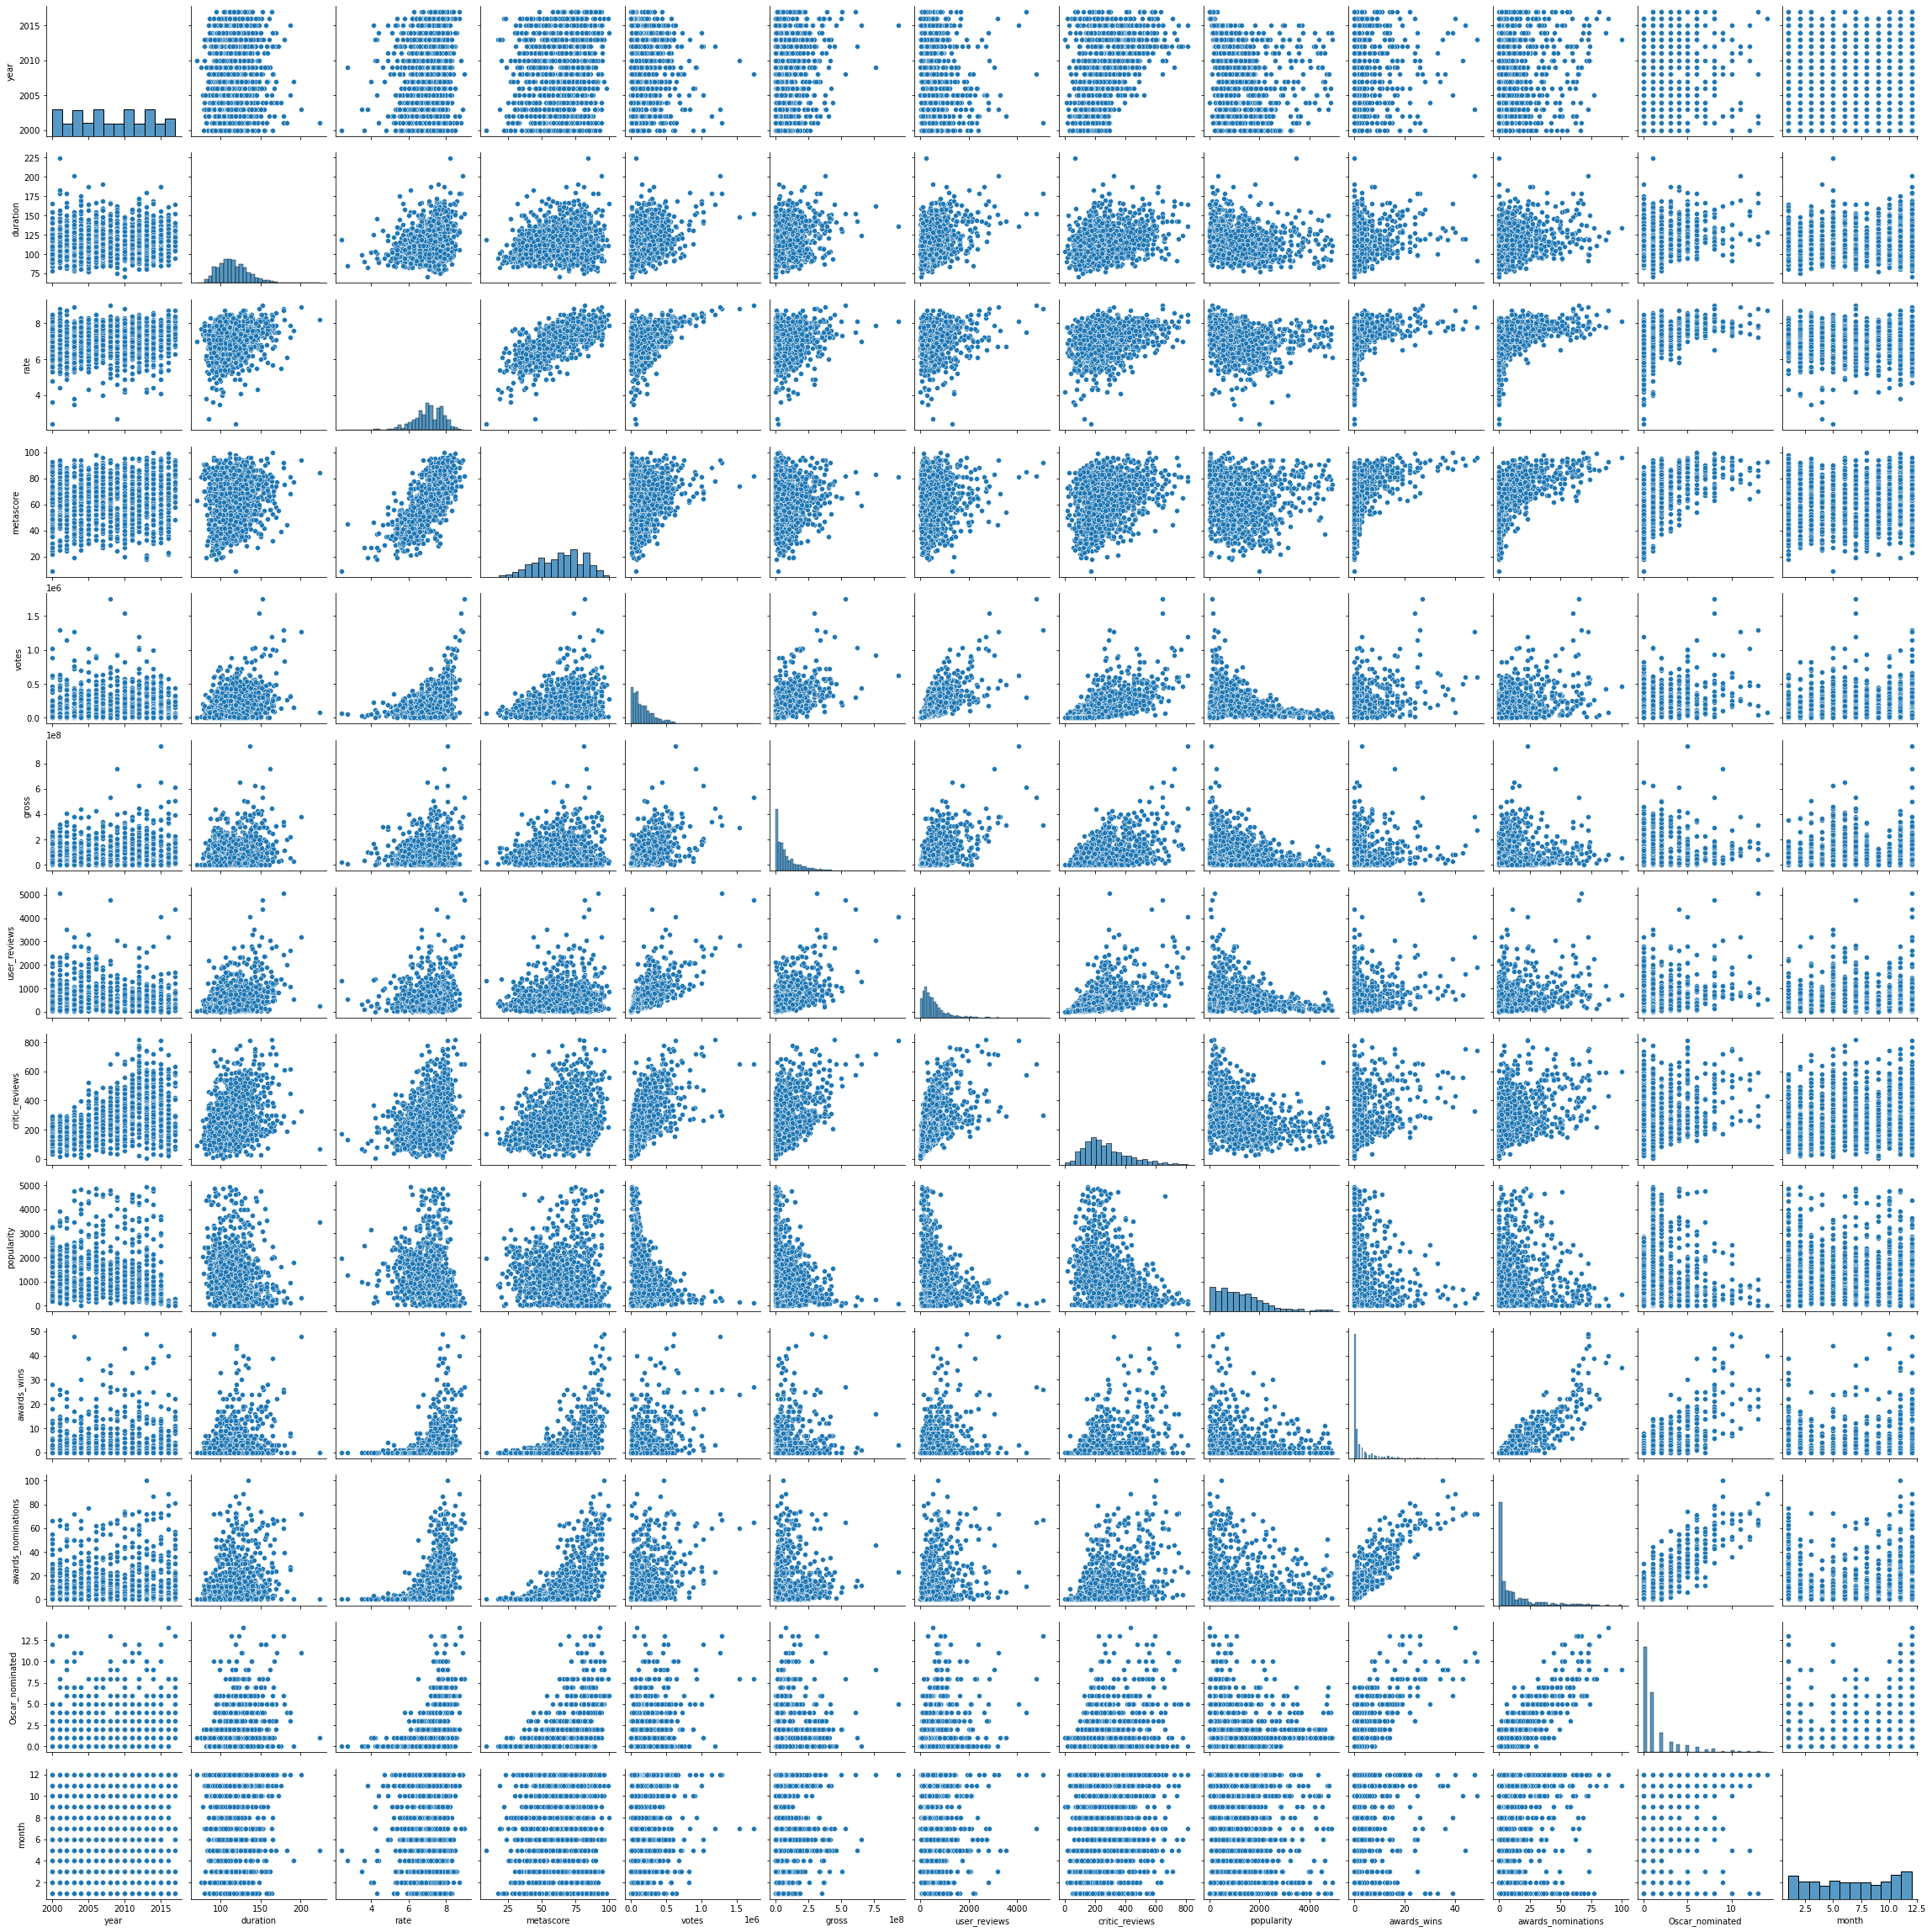

In [9]:
# Pairplot to visualize how different variables interact and introduce ourselves to the data
# by Jackson
sns.pairplot(movies_new)

In [10]:
# Correlation matrix to examine relationships with the target variable as well as prepare for potential multicollinearity concerns later 
# by Jackson
new_movies_new.corr()

,year,duration,rate,metascore,votes,gross,user_reviews,critic_reviews,popularity,awards_wins,awards_nominations,Oscar_nominated,month
year,1.000000,0.061827,0.110095,0.143086,-0.013431,0.101932,-0.165258,0.510692,-0.350531,0.057264,0.106837,0.055988,0.054556
duration,0.061827,1.000000,0.293355,0.164420,0.343586,0.258685,0.373166,0.293200,-0.167574,0.202572,0.255619,0.310108,0.096498
rate,0.110095,0.293355,1.000000,0.718046,0.396899,0.080083,0.176443,0.309725,-0.150442,0.399772,0.483175,0.440858,0.029348
metascore,0.143086,0.164420,0.718046,1.000000,0.191527,0.018431,0.073129,0.319501,-0.008611,0.495855,0.586907,0.504390,0.018394
votes,-0.013431,0.343586,0.396899,0.191527,1.000000,0.604454,0.727661,0.594040,-0.362952,0.362241,0.349058,0.299225,0.071852
gross,0.101932,0.258685,0.080083,0.018431,0.604454,1.000000,0.580119,0.470776,-0.291918,0.122324,0.107460,0.124091,0.108830
user_reviews,-0.165258,0.373166,0.176443,0.073129,0.727661,0.580119,1.000000,0.468631,-0.283762,0.291086,0.278847,0.258203,0.061109
critic_reviews,0.510692,0.293200,0.309725,0.319501,0.594040,0.470776,0.468631,1.000000,-0.339458,0.359746,0.426868,0.320785,0.074377
popularity,-0.350531,-0.167574,-0.150442,-0.008611,-0.362952,-0.291918,-0.283762,-0.339458,1.000000,-0.128351,-0.116637,-0.067159,-0.074744
awards_wins,0.057264,0.202572,0.399772,0.495855,0.362241,0.122324,0.291086,0.359746,-0.128351,1.000000,0.876319,0.773203,0.069124


<AxesSubplot:xlabel='votes', ylabel='gross'>

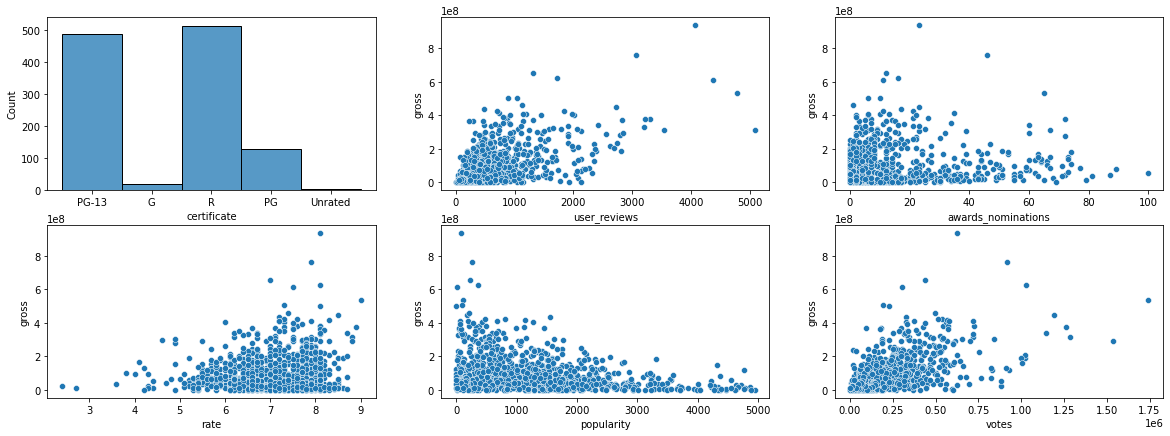

In [11]:
# Picking out a couple of the predictors we wanted to take a closer look at and examining their relationship with our target variable
# by Jackson
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,7))

sns.histplot(ax = axs[0, 0], data = new_movies_new, x = 'certificate')

sns.scatterplot(ax = axs[1, 0], data = new_movies_new, x = 'rate', y = 'gross')

sns.scatterplot(ax = axs[0, 1], data = new_movies_new, x = 'user_reviews', y = 'gross')

sns.scatterplot(ax = axs[1, 1], data = new_movies_new, x = 'popularity', y = 'gross')

sns.scatterplot(ax = axs[0, 2], data = new_movies_new, x = 'awards_nominations', y = 'gross')

sns.scatterplot(ax = axs[1, 2], data = new_movies_new, x = 'votes', y = 'gross')

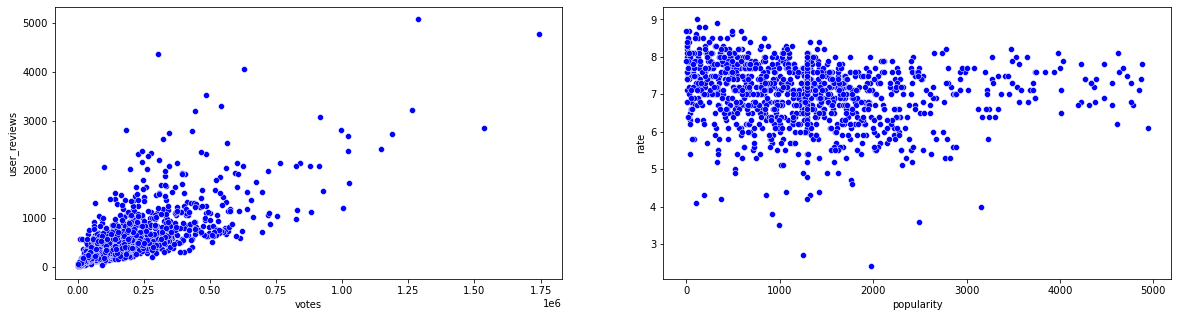

In [12]:
# Examining potential relationships or interactions between predictors that we're considering using
# by Jackson
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.scatterplot(ax = axs[0], x = new_movies_new.votes, y=new_movies_new.user_reviews, color = 'blue')
sns.scatterplot(ax = axs[1], x = new_movies_new.popularity, y=new_movies_new.rate, color = 'blue')

plt.show()

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.